<a href="https://colab.research.google.com/github/Chocoding1/Machine_Learning_Deep_Learning/blob/main/%5BDeep_Learning%5D_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이 학습(transfer learning)

방대한 자료를 통해 미리 학습한 가중치 값을 가져와 내 프로젝트에 사용하는 방법



## 치매 환자의 뇌인지 일반인의 뇌인지 예측

fatal: destination path 'data-ch20' already exists and is not an empty directory.
Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Epoch 1/100
32/32 [==============================] - 7s 190ms/step - loss: 0.7078 - accuracy: 0.4313 - val_loss: 0.6894 - val_accuracy: 0.5800
Epoch 2/100
32/32 [==============================] - 8s 255ms/step - loss: 0.6955 - accuracy: 0.5125 - val_loss: 0.6829 - val_accuracy: 0.6000
Epoch 3/100
32/32 [==============================] - 7s 222ms/step - loss: 0.6902 - accuracy: 0.5312 - val_loss: 0.6862 - val_accuracy: 0.5200
Epoch 4/100
32/32 [==============================] - 11s 319ms/step - loss: 0.6830 - accuracy: 0.5688 - val_loss: 0.6686 - val_accuracy: 0.5800
Epoch 5/100
32/32 [==============================] - 11s 350ms/step - loss: 0.6876 - accuracy: 0.5188 - val_loss: 0.6611 - val_accuracy: 0.7200
Epoch 6/100
32/32 [==============================] - 8s 238ms/step - loss: 0.6583 - accuracy: 0.6938 - val_loss: 0.6835

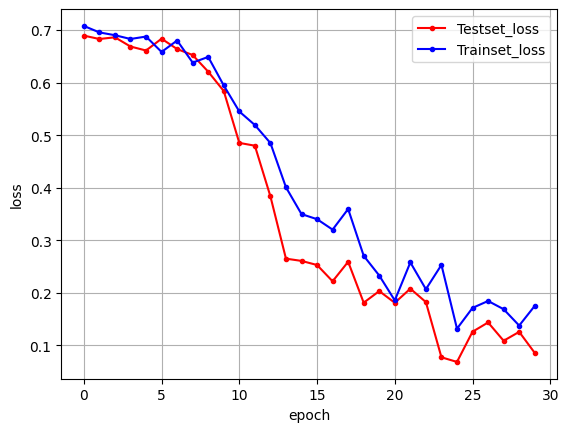

In [6]:
# 전체 코드
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

!git clone https://github.com/taehojo/data-ch20.git

# ImageDataGenerator() : data augmentation(주어진 데이터를 이용해 변형된 이미지를 만들어 학습셋에 포함시킨다)
train_datagen = ImageDataGenerator(rescale=1./255, # 주어진 이미지의 픽셀 크기 조정(0~255 -> 0~1)
                                   horizontal_flip=True, # 주어진 이미지를 50% 확률로 수평으로 뒤집어 추가
                                   width_shift_range=0.1, # 정해진 범위 안에서 이미지를 수평으로 랜덤 평행 이동
                                   height_shift_range=0.1, # 정해진 범위 안에서 이미지를 수직으로 랜덤 평행 이동
                                   #rotation_ragnge=5, # 정해진 각도만큼 이미지 회전
                                   #shear_range=0.7, # 좌표 하나를 고정시키고 다른 몇 개의 좌표 이동 변환
                                   #zoom_range=[0.9, 2.2], # 정해진 범위 안에서 이미지 축소 or 확대
                                   #vertical_flip=True, # 주어진 이미지를 수직으로 뒤집기
                                   #fill_mode='nearest # 이미지 축소 또는 회전하거나 이동할 때 생기는 빈 공간을 어떻게 채울지(nearest : 가장 비슷한 색으로 채워)
                                   )

# flow_from_directory() : 실제 데이터 경로 알려주고 이미지 불러오기
train_generator = train_datagen.flow_from_directory(
    './data-ch20/train', # 학습셋이 있는 폴더 위치
    target_size=(150,150), # 이미지 크기
    batch_size=5,
    class_mode='binary' # 치매/정상 이진 분류이므로 바이너리 모드로 실행
)

# 테스트셋은 데이터 부풀리기 진행 x
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    './data-ch20/test',
    target_size=(150,150),
    batch_size=5,
    class_mode='binary'
)

# 이미지 분류이기 때문에 CNN 모델 만들어 적용
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델 실행 옵션 설정
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 실행
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    validation_steps=10,
    callbacks=[early_stopping_callback]
)

# 검증셋 학습셋 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 전이 학습으로 모델 성능 극대화

- ImageNet 데이터셋에서 추출한 정보를 가져와 치매/일반인 뇌 사진 분류해보자.
- 뇌 사진만 다루는 치매 분류기를 만드는데, 뇌 사진과 관련 없는 수백만 장의 이미지넷 학습 정보가 큰 역할을 하는 이유 : '형태'를 구분하는 기본적인 학습이 되어있기 때문
- 예를 들어 딥러닝은 학습이 시작되면 어떤 픽셀의 조합이 선이고 어떤 형태의 그룹이 면이 되는지부터 파악해야 하는데, 이는 많은 시간이 드는 작업이다.
- 전이 학습을 하면 이러한 부분에서 시간을 단축할 수 있는 것

<br>
전이 학습 적용 방법<br>
1. 대규모 데이터셋에서 학습된 기존의 네트워크 불러오기<br>
2. CNN 모델의 앞쪽이 이 네트워크로 채우기<br>
3. 뒤 쪽 레이어에서 내 프로젝트와 연결하기<br>
4. 두 네트워크가 잘 맞물리게끔 미세 조정(fine tuning)하기

In [ ]:
# 앞서 만든 모델에 VGGNet(ImageNet 데이터셋에서 미리 학습된 모델) 가져오기
# VGGNet : 옥스포드 대학의 연구팀 VGG에 의해 개발된 모델(2014년 이미지 인식 대회에서 2위를 차지한 모델)
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
# include_top : VGG16의 마지막 층, 즉 분류를 담당하는 곳을 불러올지 말지 정하는 옵션(여기서는 뒤에 앞선 모델을 연결할 것이므로 False)
transfer_model.trainable=False # 불러오는 보분은 새롭게 학습되는 것이 아니므로 학습되지 않도록 설정

In [ ]:
# 모델 합치기
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))

fatal: destination path 'data-ch20' already exists and is not an empty directory.
Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                524352    
                                                                 
 activation_20 (Activation)  (None, 64)                0         
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                       

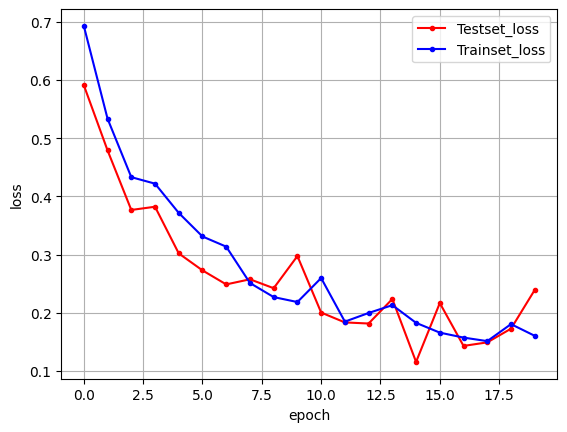

In [7]:
# 전이 학습 전체 코드
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

!git clone https://github.com/taehojo/data-ch20.git

# 학습셋 변형 설정
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   )

train_generator = train_datagen.flow_from_directory(
    './data-ch20/train',
    target_size=(150,150),
    batch_size=5,
    class_mode='binary'
)

# 테스트셋 정규화 설정
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    './data-ch20/test',
    target_size=(150,150),
    batch_size=5,
    class_mode='binary'
)

# VGG16 모델 불러오기
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
transfer_model.trainable=False

# 전이 학습 모델 설정
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

# 모델 실행 옵션 설정
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 실행
history = finetune_model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    validation_steps=10,
    callbacks=[early_stopping_callback]
)

# 그래프화
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()